# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

In [1]:
%matplotlib inline

import warnings
import itertools
import numpy as np
import datetime
warnings.filterwarnings("ignore")

import lightgbm as lgb

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from pandas.io.json import json_normalize
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats

PROJ_ROOT = os.pardir

## Import Data

In [2]:
riders_data_path = os.path.join(PROJ_ROOT, "data", "raw", "ultimate_data_challenge.json")

# Read json data into dataframe
try:
    df = pd.read_json(riders_data_path)
except:
    print("Unable to load JSON into Pandas DataFrame")

Unable to load JSON into Pandas DataFrame


In [3]:
# Read json file by line
users = open(riders_data_path,'r').readline()
users = json.loads(users)

# Create dataframe from json object
df = pd.DataFrame(users)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Data description
    ● city: city this user signed up in
    ● phone: primary device for this user
    ● signup_date: date of account registration; in the form ‘YYYY MM DD’
    ● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
    ● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    ● avg_rating_by_driver: the rider’s average rating over all of their trips
    ● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
    ● surge_pct: the percent of trips taken with surge multiplier > 1
    ● avg_surge: The average surge multiplier over all of this user’s trips
    ● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
    ● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
    ● weekday_pct: the percent of the user’s trips occurring during a weekday

## Data Type & Structure

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
# Fill null values in avg_rating_of_driver with mean value of available ratings
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(np.mean(df.avg_rating_of_driver))

# Fill null values in avg_rating_by_driver with mean value of available ratings
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(np.mean(df.avg_rating_by_driver))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
# Check proportion of unique values in phone
df['phone'].value_counts(normalize=True)

iPhone     0.697162
Android    0.302838
Name: phone, dtype: float64

In [7]:
# Fill null values in phone proportional to existing values
df['phone'] = df['phone'].fillna(pd.Series(np.random.choice(['Android', 'iPhone'], 
                                                      p=[0.3, 0.7], size=len(df))))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [8]:
# Convert signup_date and last_trip_date into datetime types
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [11]:
# Find the latest last_trip_date as the date the sample data was taken
sample_date = df['last_trip_date'].sort_values(ascending=False).head(1)
active_date = sample_date - datetime.timedelta(days=30)
active_date

45357   2014-06-01
Name: last_trip_date, dtype: datetime64[ns]

In [12]:
# Extend dataset with retained - a feature that describes whether a user was active 30 days before the sample data was taken
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x >= active_date.values[0] else 0)

In [13]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


#### Q: Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [14]:
df['retained'].value_counts(normalize=True)

0    0.62392
1    0.37608
Name: retained, dtype: float64

A: 38% of the observed users were retained.

In [15]:
# Convert ultimate_black_user and phone values to 1 and 0 values, and drop unnecessary columns
df['ultimate_black_user'] = df['ultimate_black_user'].apply(lambda x: 1 if x else 0)
df['phone'] = df['phone'].apply(lambda x: 1 if x == 'iPhone' else 0)
df.drop(['signup_date','last_trip_date'],axis=1,inplace=True)
df.head(1)

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.1,1,15.4,1,46.2,3.67,5.0,1


Of those who are not ultimate black users, significantly more are not retained. Of those who are ultimate black users, about equal numbers of users are retained vs. not retained.

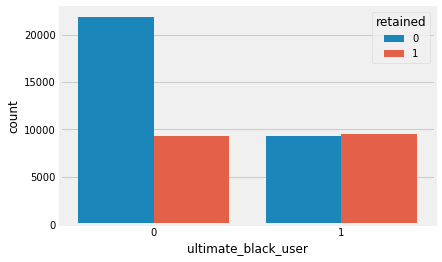

In [19]:
sns.countplot(x='ultimate_black_user', data=df, hue='retained');

Of those who live in King's Landing, more are retained. Of those who live in Astapor and Winterfell, significantly more are not retained vs. retained.

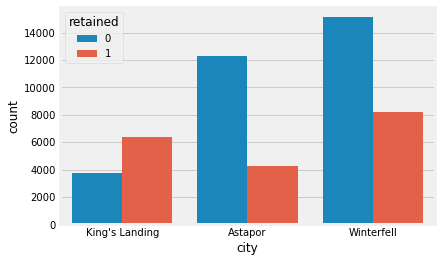

In [20]:
sns.countplot(x='city', data=df, hue='retained');

Of those who have Android phones, significantly more are not retained. Of those who have iPhones, the number who are retained vs. not retained are comparable.

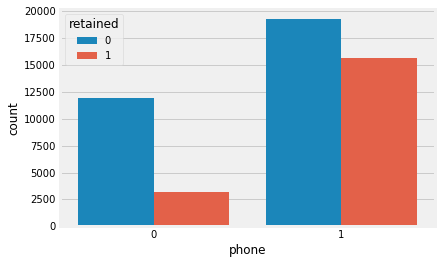

In [21]:
sns.countplot(x='phone', data=df, hue='retained');

In [27]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,0.697260,8.849536,0.37708,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.564977,0.222336,0.459448,19.958811,0.48466,37.081503,5.707357,0.445753,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.700000,1.000000,1.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,1.000000,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,1.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000


Someone took 125 trips in the first 30 days! That's more than 4 trips a day. Most observed users took less than 7 trips in the first 30 days. The distribution of all the continuous features is non-normal and highly skewed, which means that PCA could be performed to scale the continuous features into normal distribution and reduced into principal components

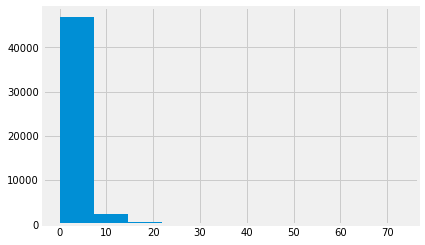

In [29]:
df['trips_in_first_30_days'].hist()
plt.show();

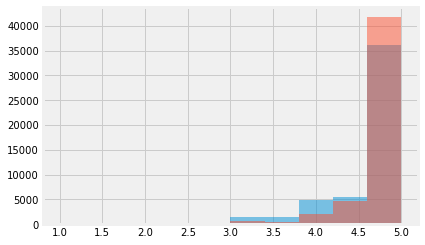

In [37]:
df['avg_rating_of_driver'].hist(alpha=0.5,label='avg_rating_of_driver')
df['avg_rating_by_driver'].hist(alpha=0.5,label='avg_rating_by_driver')
plt.show();

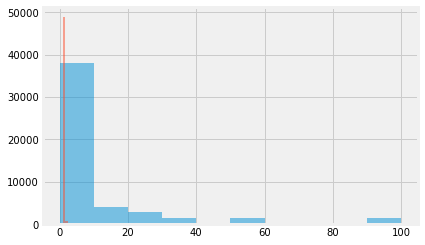

In [38]:
df['surge_pct'].hist(alpha=0.5,label='surge_pct')
df['avg_surge'].hist(alpha=0.5,label='avg_surge')
plt.show();

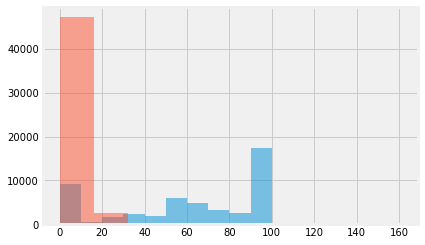

In [39]:
df['weekday_pct'].hist(alpha=0.5,label='weekday_pct')
df['avg_dist'].hist(alpha=0.5,label='avg_dist')
plt.show();

## Feature Selection & Principal Component Analysis

In [32]:
# Map values in city to numeric values
df['city'] = df['city'].apply(lambda x: 1 if x == "King's Landing" else 2 if x == 'Astapor' else 3)

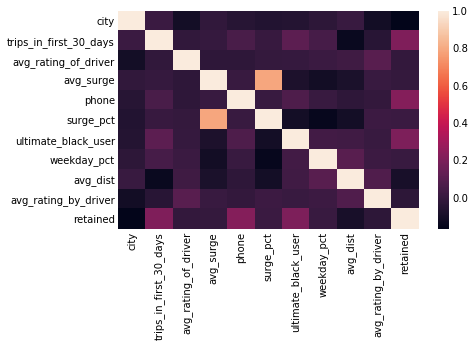

In [33]:
# Correlations between features
sns.heatmap(df.corr());

The only features with higher correlation are surge_pct and avg_surge. This makes sense since the more trips a user has taken with surge multiplier greater than 1, the higher the average surge multiplier is over the user's trips. The correlation between these two features is 0.79. We can reduce the two correlated features down to 1 feature. The features which are not high correlated can be included as is for modeling after scaling to normal distribution.

In [34]:
# Evaluate the correlation matrix to check for high correlations
df.corr()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
city,1.000000,0.012708,-0.103387,-0.013030,-0.046530,-0.056910,-0.054039,-0.026133,0.011098,-0.107464,-0.166145
trips_in_first_30_days,0.012708,1.000000,-0.011639,-0.001993,0.059402,0.005599,0.112565,0.050728,-0.137347,-0.039545,0.211863
avg_rating_of_driver,-0.103387,-0.011639,1.000000,-0.021656,-0.024430,-0.003294,-0.001934,0.012582,0.028517,0.101660,-0.010847
avg_surge,-0.013030,-0.001993,-0.021656,1.000000,0.009397,0.793582,-0.078797,-0.110072,-0.081489,0.010498,-0.003338
phone,-0.046530,0.059402,-0.024430,0.009397,1.000000,0.010824,0.073174,0.008481,-0.022356,-0.009451,0.225076
surge_pct,-0.056910,0.005599,-0.003294,0.793582,0.010824,1.000000,-0.106870,-0.144920,-0.104411,0.019964,0.011790
ultimate_black_user,-0.054039,0.112565,-0.001934,-0.078797,0.073174,-0.106870,1.000000,0.035991,0.032328,0.009327,0.204976
weekday_pct,-0.026133,0.050728,0.012582,-0.110072,0.008481,-0.144920,0.035991,1.000000,0.101657,0.020366,0.009685
avg_dist,0.011098,-0.137347,0.028517,-0.081489,-0.022356,-0.104411,0.032328,0.101657,1.000000,0.079794,-0.092765
avg_rating_by_driver,-0.107464,-0.039545,0.101660,0.010498,-0.009451,0.019964,0.009327,0.020366,0.079794,1.000000,-0.026750


In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler

# Extract the correlated features from dataframe and scale them to normal distribution
surge_scaled = scale(df[['surge_pct','avg_surge']].values)

# Instantiate and perform principal component analysis to reduce the dimension from 7 to 5
pca = PCA(n_components=1)
pc = pca.fit_transform(surge_scaled)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.89679107]


In [44]:
# Create dataframe with the principal component, scaled continuous features, and the categorical features
ml = pd.DataFrame(data={'pc':[item for sublist in pc for item in sublist],
                        'city':df['city'],
                        'trips_in_first_30_days':scale(df['trips_in_first_30_days'].values),
                        'avg_rating_of_driver':scale(df['avg_rating_of_driver'].values),
                        'weekday_pct':scale(df['weekday_pct'].values),
                        'avg_dist':scale(df['avg_dist'].values),
                        'ultimate_black_user':df['ultimate_black_user'],
                        'phone':df['phone']
                       })

In [45]:
# Dataframe for machine learning
ml.head()

,pc,city,trips_in_first_30_days,avg_rating_of_driver,weekday_pct,avg_dist,ultimate_black_user,phone
0,0.312339,1,0.459463,0.174254,-0.397122,-0.372661,1,1
1,-0.551293,2,-0.606419,0.705252,-0.294645,0.431567,0,0
2,-0.551293,2,0.192992,-0.533744,1.053738,-0.880780,0,1
3,0.602523,1,1.791814,-0.002746,0.514385,-0.602191,1,1
4,0.471029,3,3.124166,-0.356745,0.579107,-0.467277,0,0


## Sampling Strategy
Before performing over sampling, 38% of users were retained, 18803 samples are in class 1 and 31196 samples are in class 0. 

In [46]:
df['retained'].value_counts()

0    31196
1    18803
Name: retained, dtype: int64

After performing the sampling strategy, 24956 samples are in class 1 and 31196 samples are in class 0.

In [49]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

sampling_strategy = 0.8

ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X = ml[['pc', 'city','trips_in_first_30_days','avg_rating_of_driver','weekday_pct','avg_dist','ultimate_black_user','phone']].values
y = df['retained'].values
X_res, y_res = ros.fit_resample(X, y)
print('Information of the data set after making it '
      'balanced using a float and an over-sampling method: \n '
      'sampling_strategy={} \n y: {}'
      .format(sampling_strategy, Counter(y_res)))

Information of the data set after making it balanced using a float and an over-sampling method: 
 sampling_strategy=0.8 
 y: Counter({0: 31196, 1: 24956})


#### Q: Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

## Benchmarking

In [51]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
SEED = 123

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=SEED)

# Baseline model using dummy classifier
baseline = DummyClassifier(strategy='prior')

# Fit to training data
baseline.fit(X_train, y_train)

# Predict on test set
y_pred_base = baseline.predict(X_test)

# Evaluate baseline scores
accuracy_score(y_train, baseline.predict(X_train))
accuracy_score(y_test, y_pred_base)

0.5555621512525228

## Decision Tree

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import make_scorer
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 

# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
param_grid = {"max_depth": [3, 5, 7, 9],
              "max_features": [1,2],
              "min_samples_leaf": [0.1,1,2],
              "criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring=scoring, cv=5, refit='AUC', return_train_score=True)

# Fit to training data
grid_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best score is {}".format(grid_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 2, 'min_samples_leaf': 2}
Best score is 0.8120118984019674


In [54]:
# Obtain the optimal decision tree model
dt_tuned = grid_cv.best_estimator_

# Fit on training set and predict on test set
dt_tuned.fit(X_train, y_train)
y_pred_tuned = dt_tuned.predict(X_test)

# Print the accuracy score on the test set
accuracy_score(y_train, dt_tuned.predict(X_train))
accuracy_score(y_test, y_pred_tuned)

0.7466460880921287

The first model is built using the decision tree classifier from scikit-learn. The decision tree algorithm is easy to interpret and efficient to run. First, we use GridSearchCV to tune the parameters in a decision tree classifier and obtain the optimal classifier. Second, we fit the optimal model to training data so that it learns how to best predict retention, and then predict on test data to obtain the results.

The decision tree classifier with tuned parameters provides a model with an accuracy score of 0.75 on the test set. A classification rate of 75% is considered good accuracy. The feature importances from the decision tree classifier shows weekday_pct as the most important predictor of retention and city comes in second. 

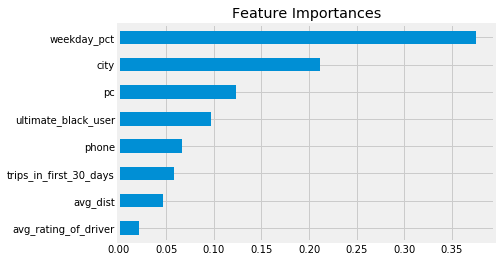

In [57]:
# Create series of the feature importances and sort the values
importances = pd.Series(dt_tuned.feature_importances_, index=['pc', 'city','trips_in_first_30_days','avg_rating_of_driver','weekday_pct','avg_dist','ultimate_black_user','phone']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show();

## Gradient Boosting

In [58]:
# Instantiate Gradient Boosting classifier
gb = GradientBoostingClassifier(n_estimators=300, max_depth = 3, max_features = 3, min_samples_leaf = 2, random_state=SEED)

# Fit to training data
gb.fit(X_train, y_train)

# Predict the labels on test data
y_pred_gb = gb.predict(X_test)

# Evaluate the accuracy
accuracy_score(y_test, y_pred_gb)

0.7767422533539119

The second predictive model is fitted using the Gradient Boosting classifier and its prediction on the test set has an accuracy score of 78%, which is an improvement from the decision tree classifier. The gradient boosting classifier also placed weekday_pct as the top feature in predicting retention, but unlike the decision tree, it placed the principal component which contains avg_surge and surge_pct as the second most important predictor, followed closely by city. 

Since the gradient boosting classifier has higher accuracy in predicting retention than the decision tree classifier, we will use its feature importances in our interpretation of the final results.

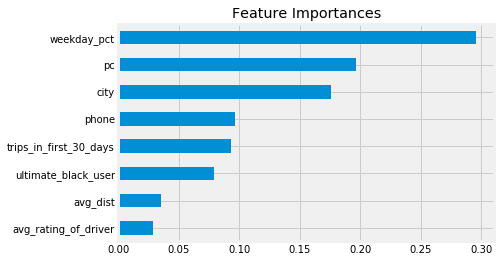

In [63]:
# Create series of the feature importances and sort the values
importances = pd.Series(gb.feature_importances_, index=['pc', 'city','trips_in_first_30_days','avg_rating_of_driver','weekday_pct','avg_dist','ultimate_black_user','phone']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show();

In [71]:
# Compare the statistics of weekday_pct for users that are retained (class 1) and not retained (class 0)
df[df['retained']==1]['weekday_pct'].describe()

count    18803.000000
mean        61.388470
std         29.488267
min          0.000000
25%         44.400000
50%         64.300000
75%         84.600000
max        100.000000
Name: weekday_pct, dtype: float64

In [72]:
# statistics of weekday_pct of unretained users
df[df['retained']==0]['weekday_pct'].describe()

count    31196.000000
mean        60.647032
std         40.982688
min          0.000000
25%         16.700000
50%         69.600000
75%        100.000000
max        100.000000
Name: weekday_pct, dtype: float64

Surprisingly when comparing the weekday_pct of retained and unretained users, the means and medians are very close to each other. The only difference in the distribution of weekday_pct between the two classes is that significantly more unretained users have extreme percentages of rides that occur during the weekdays. Many unretained users have either very low (0 to 10%) or very high (90 to 100%) percentages of weekday rides.

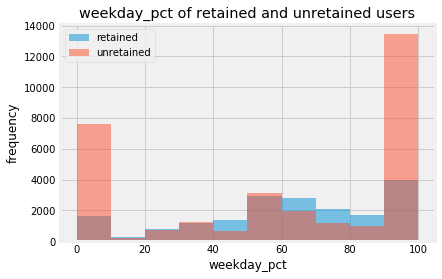

In [70]:
plt.hist(df[df['retained']==1]['weekday_pct'],alpha=0.5,label='retained')
plt.hist(df[df['retained']==0]['weekday_pct'],alpha=0.5,label='unretained')
plt.title('weekday_pct of retained and unretained users')
plt.xlabel('weekday_pct')
plt.ylabel('frequency')
plt.legend()
plt.show();

During exploratory data analysis, we saw that Astapor has the poorest retention rate among the cities and King's landing has the best retention rate. Both Astapor and Winterfell have more than double the number of users who have very low or very high percentage of weekday rides.

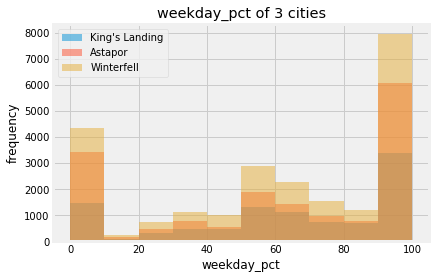

In [84]:
plt.hist(df[df['city']==1]['weekday_pct'],alpha=0.5,label="King's Landing")
plt.hist(df[df['city']==2]['weekday_pct'],alpha=0.5,label='Astapor')
plt.hist(df[df['city']==3]['weekday_pct'],alpha=0.5,label='Winterfell')
plt.title('weekday_pct of 3 cities')
plt.xlabel('weekday_pct')
plt.ylabel('frequency')
plt.legend()
plt.show();

For the principal component which contains surge_pct and avg_surge that is the second most important predictor of retention, the main difference in the surge between the two classes is that unretained users take many more trips with surge multiplier greater than 1. Unretained users also have higher average surge multipliers over their trips. 

In [77]:
df[df['retained']==1]['surge_pct'].describe()

count    18803.000000
mean         9.152518
std         15.589071
min          0.000000
25%          0.000000
50%          0.000000
75%         13.300000
max        100.000000
Name: surge_pct, dtype: float64

In [78]:
df[df['retained']==0]['surge_pct'].describe()

count    31196.000000
mean         8.666739
std         22.179139
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: surge_pct, dtype: float64

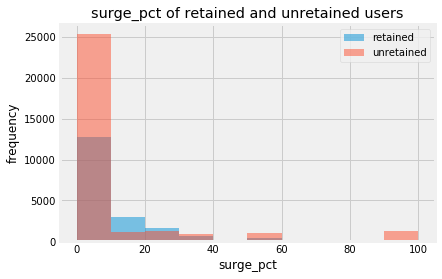

In [73]:
plt.hist(df[df['retained']==1]['surge_pct'],alpha=0.5,label='retained')
plt.hist(df[df['retained']==0]['surge_pct'],alpha=0.5,label='unretained')
plt.title('surge_pct of retained and unretained users')
plt.xlabel('surge_pct')
plt.ylabel('frequency')
plt.legend()
plt.show();

In [75]:
df[df['retained']==1]['avg_surge'].describe()

count    18803.000000
mean         1.073807
std          0.163174
min          1.000000
25%          1.000000
50%          1.000000
75%          1.090000
max          4.500000
Name: avg_surge, dtype: float64

In [76]:
df[df['retained']==0]['avg_surge'].describe()

count    31196.000000
mean         1.075339
std          0.251361
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: avg_surge, dtype: float64

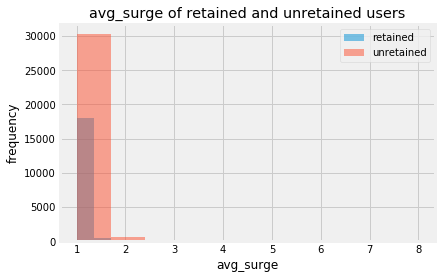

In [74]:
plt.hist(df[df['retained']==1]['avg_surge'],alpha=0.5,label='retained')
plt.hist(df[df['retained']==0]['avg_surge'],alpha=0.5,label='unretained')
plt.title('avg_surge of retained and unretained users')
plt.xlabel('avg_surge')
plt.ylabel('frequency')
plt.legend()
plt.show();

Since city is the third most important predictor, comparing the distribution of surge_pct between the 3 cities reveals that King's Landing, the only city with more users retained than not, 

In [81]:
df[df['city']==1]['surge_pct'].describe()

count    10129.000000
mean         9.966542
std         18.832913
min          0.000000
25%          0.000000
50%          0.000000
75%         14.300000
max        100.000000
Name: surge_pct, dtype: float64

In [82]:
df[df['city']==2]['surge_pct'].describe()

count    16534.000000
mean        10.140305
std         21.947097
min          0.000000
25%          0.000000
50%          0.000000
75%         10.700000
max        100.000000
Name: surge_pct, dtype: float64

In [83]:
df[df['city']==3]['surge_pct'].describe()

count    23336.000000
mean         7.449927
std         18.832043
min          0.000000
25%          0.000000
50%          0.000000
75%          4.500000
max        100.000000
Name: surge_pct, dtype: float64

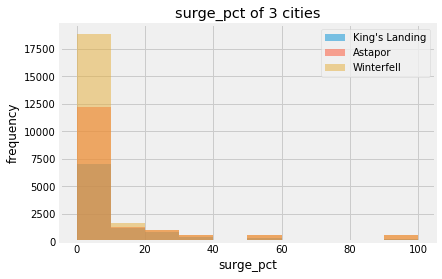

In [79]:
plt.hist(df[df['city']==1]['surge_pct'],alpha=0.5,label="King's Landing")
plt.hist(df[df['city']==2]['surge_pct'],alpha=0.5,label='Astapor')
plt.hist(df[df['city']==3]['surge_pct'],alpha=0.5,label='Winterfell')
plt.title('surge_pct of 3 cities')
plt.xlabel('surge_pct')
plt.ylabel('frequency')
plt.legend()
plt.show();

#### Q: Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

A: Findings:
1. Users who don't only take weekday or weekend rides, but use the app more consistently both during the week as well as on the weekends are more likely to be retained 6 months after sign up.
2. Users in King's Landing take rides more balanced and consistently both on weekdays and on the weekends, whereas users in Astapor and Winterfell tend to take rides only on the weekdays, or only on the weekends.
3. Users who experienced less average surge on their rides are more likely to be retained 6 months after sign up.
4. Users in King's Landing experienced less average surge on their rides. Users in Astapor and Winterfell experienced more surges and higher average surge on the rides.

Perhaps many users who only took a ride on the weekday or weekend used the app as an emergency and had to choose to take the surge multiplied rides regardless of how high the multiplier is. This may have deterred the users from taking rides as an everyday transportation tool. Ultimate could experiment with exempting the surge for first time riders in Astapor and Winterfell to see if it improves retention in these cities. 
